### Hypothesis for Soybean directional, using the oilseeds complex as a lead driver.
* We will test the relationship of the crush components of soybeans and its short term impact on directionality

### Building a Auto Regression Model for Soybeans

* We will use Pytorch for the Linear Regression Model
* The variables will be the crush skew and crush for the dependents
* We will perform a time series analysis using auto regression.


# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import yfinance as yf



                           Close_ZS  Volume_ZS    Close_ZM  Volume_ZM  \
Datetime                                                                
2024-10-31 23:00:00-05:00   1002.25     4201.0  299.200012     1026.0   
2024-11-01 03:00:00-05:00   1001.25     5062.0  298.899994     2763.0   
2024-11-01 07:00:00-05:00    993.25    52059.0  295.600006    33141.0   

                            Close_ZL  Volume_ZL  
Datetime                                         
2024-10-31 23:00:00-05:00  46.189999     1618.0  
2024-11-01 03:00:00-05:00  46.110001     7106.0  
2024-11-01 07:00:00-05:00  45.860001    45311.0  
Bars kept (open hours): 1251
Uniform grid bars: 1249
Compact (gapless) shape: (1249, 6)


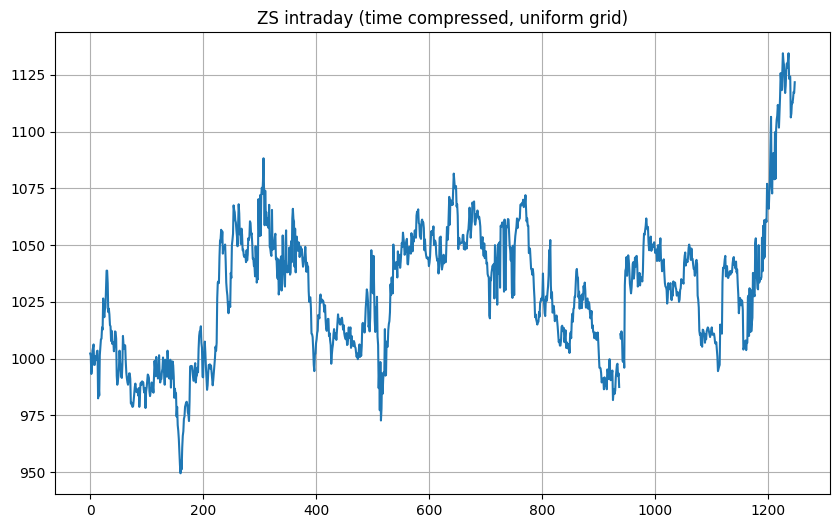

In [12]:
# --- CME grains intraday loader: clean trading-hours series with uniform grid ---
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import time as dtime
from typing import List, Tuple, Optional

# ----------------------------- Data download -----------------------------------
def download_intraday_yf(
    tickers: List[str],
    start: str,
    end: str,
    interval: str = "4h",
    fields: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Download intraday data from yfinance for multiple tickers and flatten columns.
    Returns a tz-aware (UTC) DateTimeIndex DataFrame with columns like 'Close_ZS', 'Volume_ZS'.
    """
    if fields is None:
        fields = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

    raw = yf.download(
        tickers,
        start=start,
        end=end,
        interval=interval,
        group_by="ticker",
        auto_adjust=False,
        prepost=False,
        threads=True,
        progress=False,
    )

    # Handle single vs multi-ticker shapes
    if isinstance(raw.columns, pd.MultiIndex):
        raw.columns = [f"{f}_{t.replace('=F','')}" for (t, f) in raw.columns]
    else:
        # Single-ticker fallback naming
        t = tickers[0].replace('=F', '')
        raw = raw.rename(columns={c: f"{c}_{t}" for c in raw.columns})

    # Keep only requested fields across all tickers
    keep = [c for c in raw.columns if any(c.startswith(f) for f in fields)]
    df = raw[keep].copy()

    # Ensure tz-aware UTC index (yfinance intraday should be UTC already; safety net)
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")

    # Sort early; some providers return slightly out-of-order rows
    df = df.sort_index()
    return df

# ----------------------- Trading-hours filtering (CME) --------------------------
def filter_cme_hours(
    df: pd.DataFrame,
    tz_exchange: str = "America/Chicago",
    include_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Filter a tz-aware intraday DataFrame to only CME grains hours (ZS/ZM/ZL).
    Returns a time-indexed DataFrame in exchange tz (no compression yet).

    Trading windows (Central Time):
      • Sun–Thu 17:00 → next day 07:45  (overnight)
      • Mon–Fri 08:30 → 13:20          (day session)
    Closed:
      • 07:45–08:30 maintenance break
      • 13:20–17:00 daily
      • Fri 13:20 → Sun 17:00 weekend
    """
    if df.index.tz is None:
        raise ValueError("DataFrame index must be timezone-aware (e.g., UTC).")

    # Convert to exchange tz, sort, and drop exact-duplicate stamps (DST/provider quirks)
    data = df.tz_convert(tz_exchange).sort_index()
    data = data[~data.index.duplicated(keep="last")]

    dow = data.index.dayofweek  # Mon=0 .. Sun=6
    tod = data.index.time

    m_day = (dow <= 4) & (tod >= dtime(8, 30)) & (tod <= dtime(13, 20))          # Mon–Fri 08:30–13:20
    m_overnight_evening = np.isin(dow, [6, 0, 1, 2, 3]) & (tod >= dtime(17, 0))   # Sun–Thu 17:00–23:59
    m_overnight_morning = np.isin(dow, [0, 1, 2, 3, 4]) & (tod < dtime(7, 45))    # Mon–Fri 00:00–07:45

    open_mask = m_day | m_overnight_evening | m_overnight_morning
    filtered = data.loc[open_mask].copy()

    # Sort & de-dup once more after masking
    filtered = filtered.sort_index()
    filtered = filtered[~filtered.index.duplicated(keep="last")]

    if include_cols:
        keep = [c for c in filtered.columns if any(c.startswith(k) for k in include_cols)]
        filtered = filtered[keep]

    return filtered

# -------------------- Uniform grid per session (fix low-TF zigzag) --------------
def enforce_uniform_interval_per_session(
    df: pd.DataFrame,
    freq: str = "4h",
) -> pd.DataFrame:
    """
    Resample to a uniform grid *within* each continuous session so matplotlib
    never connects across the maintenance break or weekend. Uses 'last' to align
    with right-closed intervals (typical bar definitions).
    """
    df = df.sort_index()
    df = df[~df.index.duplicated(keep="last")]

    # Build a session id that flips when we cross between day/overnight windows.
    # (We could also use gaps > freq to segment; this approach is robust for CME hours.)
    tod = pd.Series(df.index.time, index=df.index)
    is_day = (tod >= dtime(8, 30)) & (tod <= dtime(13, 20))
    session_id = (is_day.astype(int).diff().fillna(0).ne(0)).cumsum()

    snapped = (df.groupby(session_id, group_keys=False)
                 .apply(lambda x: x.resample(freq, label="right", closed="right").last())
                 .dropna(how="all"))
    snapped = snapped.sort_index()
    snapped = snapped[~snapped.index.duplicated(keep="last")]
    return snapped

# ------------------------------- Pipeline helper --------------------------------
def load_cme_intraday_clean(
    tickers: List[str],
    start: str,
    end: str,
    raw_interval: str = "4h",     # what you ask Yahoo for
    target_freq: str = "4h",    # the uniform grid you want (e.g., '5min','15min','60min')
    fields: Optional[List[str]] = None,
    include_cols: Optional[List[str]] = None,  # e.g., ["Close","Volume"]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Full pipeline:
      1) download intraday
      2) keep CME open hours only
      3) snap to a uniform grid per session
      4) return (open_only_time_indexed, snapped_time_indexed, snapped_time_compressed)
    """
    df_raw = download_intraday_yf(tickers, start, end, interval=raw_interval, fields=fields)
    open_only = filter_cme_hours(df_raw, tz_exchange="America/Chicago", include_cols=include_cols)
    snapped   = enforce_uniform_interval_per_session(open_only, freq=target_freq)
    compact   = snapped.reset_index(drop=True)  # time-compressed for modeling
    return open_only, snapped, compact

# -------------------------------- Example usage ---------------------------------
if __name__ == "__main__":
    # Params
    tickers = ["ZS=F", "ZM=F", "ZL=F"]
    start   = "2024-11-01"
    end     = "2025-11-10"
    raw_interval = "4h"     # what to request from Yahoo (respect their lookback limits)
    target_freq  = "4h"   # force a uniform grid per session to kill zig-zag

    # Load
    open_only, uniform, ts = load_cme_intraday_clean(
        tickers=tickers,
        start=start,
        end=end,
        raw_interval=raw_interval,
        target_freq=target_freq,
        fields=["Close", "Volume"],
        include_cols=["Close", "Volume"],   # keep Close_* and Volume_* columns
    )

    # Quick sanity prints
    print(open_only.head(3))
    print("Bars kept (open hours):", len(open_only))
    print("Uniform grid bars:", len(uniform))
    print("Compact (gapless) shape:", ts.shape)

    # Optional plot (compact, no wall-clock gaps)

    ts["Close_ZS"].plot(figsize=(10, 6), grid=True)
    plt.title("ZS intraday (time compressed, uniform grid)")
    plt.show()



### Feature engineering
* Create target and lagged feature for the analysis

In [13]:
# Create crush skew formula

prices = ts.copy()
prices['crush'] = (ts['Close_ZS'] * 10) -(ts['Close_ZM'] * 11) -(ts['Close_ZL'] * 9)
prices['crush_skew'] = (ts['Close_ZS'] * 6) -(ts['Close_ZM'] * 11) -(ts['Close_ZL'] * 9)
#prices['crush'].plot(figsize=(10,8), grid=True)
prices

,Close_ZS,Volume_ZS,Close_ZM,Volume_ZM,Close_ZL,Volume_ZL,crush,crush_skew
0,1002.25,4201.0,299.200012,1026.0,46.189999,1618.0,6315.589878,2306.589878
1,1001.25,5062.0,298.899994,2763.0,46.110001,7106.0,6309.610062,2304.610062
2,993.25,52059.0,295.600006,33141.0,45.860001,45311.0,6268.159927,2295.159927
3,995.25,44037.0,295.700012,28208.0,46.430000,21642.0,6281.929863,2300.929863
4,1003.50,8247.0,299.299988,3878.0,46.380001,3545.0,6325.280125,2311.280125
...,...,...,...,...,...,...,...,...
1244,1112.50,5406.0,312.200012,2815.0,49.310001,1716.0,7247.009853,2797.009853
1245,1114.50,14219.0,314.000000,4114.0,49.439999,3271.0,7246.040012,2788.040012
1246,1117.50,47984.0,316.600006,34097.0,49.810001,51216.0,7244.109921,2774.109921
1247,1117.00,36827.0,317.100006,22721.0,49.680000,34166.0,7234.779930,2766.779930


In [14]:
target = 'zs_close_log_return'
max_lags = 4
forecast_horizon = 1

# Create log prices

prices = prices.sort_index()
prices['zs_close_log_return'] = np.log(prices['Close_ZS']/prices['Close_ZS'].shift(forecast_horizon))
prices['crush_close_log_return'] = np.log(prices['crush']/prices['crush'].shift(forecast_horizon))
prices['crush_skew_close_log_return'] = np.log(prices['crush_skew']/prices['crush_skew'].shift(forecast_horizon))
prices['zs_log_volume'] = np.log(prices['Volume_ZS']/prices['Volume_ZS'].shift(forecast_horizon))

#(prices[['Close_ZS','crush','crush_skew']] <= 0).any()

# Create lagged features.
prices[f'{target}_lag_1'] = prices[target].shift(forecast_horizon * 1)
prices[f'{target}_lag_2'] = prices[target].shift(forecast_horizon * 2)
prices[f'{target}_lag_3'] = prices[target].shift(forecast_horizon * 3)
prices[f'{target}_lag_4'] = prices[target].shift(forecast_horizon * 4)

prices['crush_close_lag_1'] = prices['crush_close_log_return'].shift(forecast_horizon * 1)
prices['crush_close_lag_2'] = prices['crush_close_log_return'].shift(forecast_horizon * 2)
prices['crush_close_lag_3'] = prices['crush_close_log_return'].shift(forecast_horizon * 3)
prices['crush_close_lag_4'] = prices['crush_close_log_return'].shift(forecast_horizon * 4)

prices['crushskew_close_lag_1'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 1)
prices['crushskew_close_lag_2'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 2)
prices['crushskew_close_lag_3'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 3)
prices['crushskew_close_lag_4'] = prices['crush_skew_close_log_return'].shift(forecast_horizon * 4)

prices['zs_log_volume_lag_1'] = prices['zs_log_volume'].shift(forecast_horizon * 1)

prices.dropna(inplace=True)
#prices

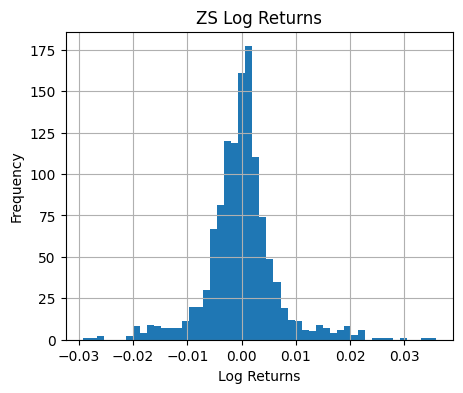

In [15]:
# Plot distribution of close log returns for Soybeans
prices['zs_close_log_return'].hist(bins=50, figsize=(5,4), grid=True)
plt.title('ZS Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

In [16]:
prices['zs_close_log_return'].agg(['mean', 'std', 'skew', 'kurt'])


mean    0.000079
std     0.006647
skew    0.350749
kurt    4.092451
Name: zs_close_log_return, dtype: float64

In [17]:
# visualize log-return quantiles
returns = prices['zs_close_log_return']
print(returns.quantile([0.001, 0.01, 0.05, 0.95, 0.99, 0.999]))


0.001   -0.027227
0.010   -0.018838
0.050   -0.010377
0.950    0.011053
0.990    0.020651
0.999    0.032771
Name: zs_close_log_return, dtype: float64


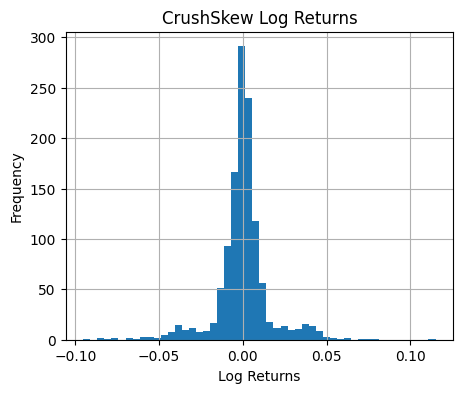

In [18]:
prices['crush_skew_close_log_return'].hist(bins=50, figsize=(5,4), grid=True)
plt.title('CrushSkew Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

### Building the Model

In [19]:
# we will use a linear model from Pytorch.

class LinearModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.linear = nn.Linear(input_features, 1)
    def forward(self, x):
        return self.linear(x)

### Splitting the model by time to ensure no data leakage

In [31]:
features = ['crushskew_close_lag_1','crushskew_close_lag_2']
target_col = 'zs_close_log_return'   # single column name (not list)
test_size = 0.25
no_epochs = 3000
lr = 5e-4
huber_delta = 0.01   # ~ hourly sigma

# ----------------- Time split -----------------
split_idx = int(len(prices) * (1 - test_size))
prices_train = prices.iloc[:split_idx].copy()
prices_test  = prices.iloc[split_idx:].copy()


In [32]:
# ----------------- Clip tails (train-only quantiles) -----------------
q_low, q_high = 0.001, 0.999
low, high = prices_train[target_col].quantile([q_low, q_high])
prices_train[target_col] = prices_train[target_col].clip(low, high)
prices_test[target_col]  = prices_test[target_col].clip(low, high)  # use train thresholds

In [33]:
# ----------------- Scale X and y (fit on train only) -----------------
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler().fit(prices_train[features].values)
y_scaler = StandardScaler().fit(prices_train[[target_col]].values)

X_train_np = x_scaler.transform(prices_train[features].values)
X_test_np  = x_scaler.transform(prices_test[features].values)
y_train_np = y_scaler.transform(prices_train[[target_col]].values)   # shape (n,1)
y_test_np  = y_scaler.transform(prices_test[[target_col]].values)

In [34]:
# ----------------- To tensors -----------------
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

In [35]:
# ----------------- Model / loss / opt -----------------
model = LinearModel(len(features))
criterion = nn.HuberLoss(delta=huber_delta)      # robust to fat tails
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training the model


In [36]:
# ----------------- Train -----------------
print("\nTraining...")
for epoch in range(no_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # periodic logging & test eval
    if (epoch + 1) % 250 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test).item()
        print(f"Epoch {epoch+1:4d}/{no_epochs} | Train {loss.item():.6f} | Test {test_loss:.6f}")

# ----------------- Inspect learned weights -----------------
print("\nLearned parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# ----------------- Predict & inverse-transform -----------------
model.eval()
with torch.no_grad():
    yhat_train = model(X_train).numpy()
    yhat_test  = model(X_test).numpy()

yhat_train_inv = y_scaler.inverse_transform(yhat_train).ravel()
yhat_test_inv  = y_scaler.inverse_transform(yhat_test).ravel()
ytrue_train_inv = y_scaler.inverse_transform(y_train_np).ravel()
ytrue_test_inv  = y_scaler.inverse_transform(y_test_np).ravel()

# ----------------- Quick sanity metrics -----------------
def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

print("\nOut-of-sample (test) MAE/RMSE (in log-return units):",
      f"{mae(ytrue_test_inv, yhat_test_inv):.6f} / {rmse(ytrue_test_inv, yhat_test_inv):.6f}")




Training...
Epoch    1/3000 | Train 0.009163 | Test 0.008522
Epoch  250/3000 | Train 0.008357 | Test 0.007942
Epoch  500/3000 | Train 0.007717 | Test 0.007447
Epoch  750/3000 | Train 0.007253 | Test 0.007048
Epoch 1000/3000 | Train 0.006892 | Test 0.006767
Epoch 1250/3000 | Train 0.006718 | Test 0.006652
Epoch 1500/3000 | Train 0.006682 | Test 0.006617
Epoch 1750/3000 | Train 0.006664 | Test 0.006607
Epoch 2000/3000 | Train 0.006657 | Test 0.006605
Epoch 2250/3000 | Train 0.006652 | Test 0.006605
Epoch 2500/3000 | Train 0.006650 | Test 0.006608
Epoch 2750/3000 | Train 0.006649 | Test 0.006611
Epoch 3000/3000 | Train 0.006648 | Test 0.006611

Learned parameters:
linear.weight:
[[-0.12236573 -0.08325094]]
linear.bias:
[-0.00454646]

Out-of-sample (test) MAE/RMSE (in log-return units): 0.004341 / 0.006737


In [37]:
y0 = ytrue_test_inv
mae_base = float(np.mean(np.abs(y0)))
rmse_base = float(np.sqrt(np.mean((y0 - 0.0)**2)))

mae_model = mae(ytrue_test_inv, yhat_test_inv)
rmse_model = rmse(ytrue_test_inv, yhat_test_inv)

print(f"Baseline MAE/RMSE: {mae_base:.6f} / {rmse_base:.6f}")
print(f"MAE skill:  {100*(1 - mae_model/mae_base):.2f}%")
print(f"RMSE skill: {100*(1 - rmse_model/rmse_base):.2f}%")


Baseline MAE/RMSE: 0.004355 / 0.006845
MAE skill:  0.33%
RMSE skill: 1.58%


In [38]:
def sign2(x): return np.where(x >= 0, 1, -1)
hit_rate = (sign2(ytrue_test_inv) == sign2(yhat_test_inv)).mean()
print(f"Directional accuracy: {100*hit_rate:.2f}%")


Directional accuracy: 54.22%


# Evaluating model performance
* Create trade results from test data

Trades: 307
Win rate: 51.47%
First/last timestamps: [935, 1248]
Per-bar mean / std: 0.000189 / 0.006847
Sharpe (annualized): nan


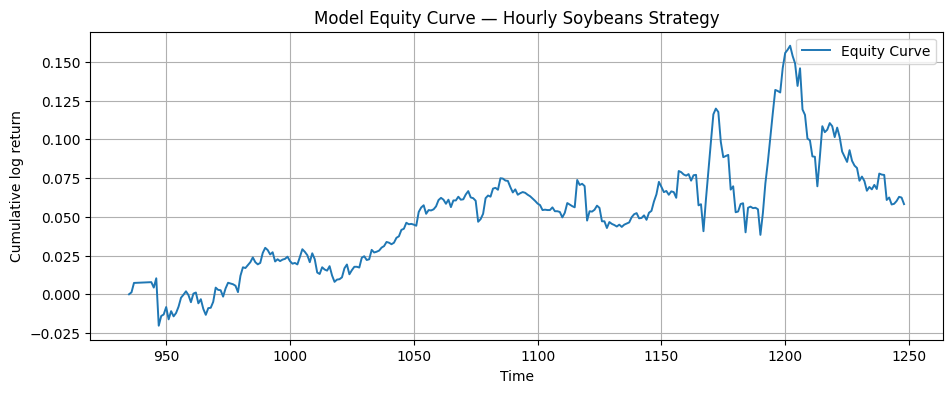

In [39]:
# yhat_test_inv, ytrue_test_inv already computed (real log-return units)
# prices_test is your TEST slice (with a proper DatetimeIndex)

import pandas as pd
import numpy as np

# --- Assemble with timestamp for sanity checks ---
trade_results = pd.DataFrame({
    'timestamp': prices_test.index,           # must be DatetimeIndex, not compressed ints
    'y_hat': np.squeeze(yhat_test_inv),       # predicted log return for bar t
    'y':     np.squeeze(ytrue_test_inv),      # realized log return for bar t
})

# --- Enforce strict alignment & monotonic time ---
trade_results = trade_results.sort_values('timestamp').reset_index(drop=True)

# --- Generate signal and APPLY IT TO NEXT BAR to avoid any lookahead ---
trade_results['signal_t'] = np.sign(trade_results['y_hat'])   # signal "decided" at end of bar t
trade_results['signal'] = -np.sign(trade_results['y_hat']).shift(1)
# execute on bar t+1
trade_results.loc[0, 'signal'] = 0  # no trade on the very first bar

# (Optional) small tie-breaker to avoid zeros from tiny preds:
# trade_results['signal_t'] = np.where(trade_results['y_hat'] >= 0, 1.0, -1.0)

# --- Realized PnL in log space ---
trade_results['trade_log_return'] = trade_results['signal'] * trade_results['y']
trade_results['equity_curve'] = trade_results['trade_log_return'].cumsum()

# --- Basic stats ---
trade_results['is_won'] = np.sign(trade_results['signal']) == np.sign(trade_results['y'])
win_rate = trade_results.loc[trade_results['signal']!=0, 'is_won'].mean()

print("Trades:", int((trade_results['signal']!=0).sum()))
print(f"Win rate: {win_rate*100:.2f}%")
print("First/last timestamps:", trade_results['timestamp'].iloc[[0,-1]].to_list())

# --- Sharpe with real timestamps (handles tz) ---
def annualized_sharpe_from_returns(ret: pd.Series, ts: pd.Series):
    mu = float(ret.mean()); sd = float(ret.std(ddof=1))
    if not np.isfinite(sd) or sd == 0: return mu, sd, float('nan')
    idx = pd.to_datetime(ts)
    if getattr(idx, 'tz', None) is not None:
        idx = idx.tz_convert(None)
    years = (idx.iloc[-1] - idx.iloc[0]).total_seconds() / (365.25*24*3600)
    if years <= 0: return mu, sd, float('nan')
    bpy = len(idx) / years
    return mu, sd, (mu/sd)*np.sqrt(bpy)

mu, sd, sharpe = annualized_sharpe_from_returns(trade_results['trade_log_return'],
                                                trade_results['timestamp'])
print(f"Per-bar mean / std: {mu:.6f} / {sd:.6f}")
print(f"Sharpe (annualized): {sharpe:.2f}")

# --- Equity plot by time (so you see *when* the jump occurs) ---
import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.plot(trade_results['timestamp'], trade_results['equity_curve'], label='Equity Curve', lw=1.4)
plt.title("Model Equity Curve — Hourly Soybeans Strategy")
plt.xlabel("Time"); plt.ylabel("Cumulative log return"); plt.grid(True); plt.legend(); plt.show()

# --- Rolling hit-rate (sanity) ---
roll = 100
trade_results['hit'] = (np.sign(trade_results['signal']) == np.sign(trade_results['y'])).astype(float)
trade_results['hr_roll'] = trade_results['hit'].rolling(roll, min_periods=roll).mean()


Text(0.5, 1.0, 'Predicted vs Real Next-Bar Log Return')

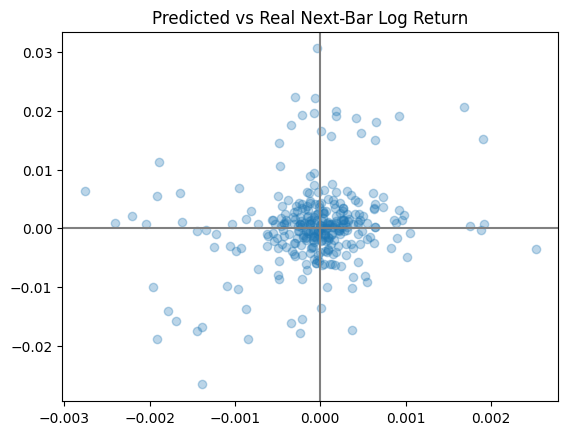

In [40]:

plt.scatter(trade_results['y_hat'], trade_results['y'], alpha=0.3)
plt.axhline(0, color='gray'); plt.axvline(0, color='gray')
plt.title("Predicted vs Real Next-Bar Log Return")


### Visualize the equity curve in log space

In [41]:
# Calculate drawdown from the cumulative equity curve
trade_results['drawdown_log'] = trade_results['equity_curve'] - trade_results['equity_curve'].cummax()


trade_results.head()


,timestamp,y_hat,y,signal_t,signal,trade_log_return,equity_curve,is_won,hit,hr_roll,drawdown_log
0,935,-0.000016,-0.005528,-1.0,0.0,-0.000000,-0.000000,False,0.0,NaN,0.000000
1,936,0.000325,0.001259,1.0,1.0,0.001259,0.001259,True,1.0,NaN,0.000000
2,937,0.000113,-0.006058,1.0,-1.0,0.006058,0.007317,True,1.0,NaN,0.000000
3,944,0.000490,-0.000501,1.0,-1.0,0.000501,0.007817,True,1.0,NaN,0.000000
4,945,0.000632,0.003499,1.0,-1.0,-0.003499,0.004318,False,0.0,NaN,-0.003499


In [42]:
#for x in trade_results['signal']:
    #print(x)

### Trading performance breakdown

In [43]:
# Max DD log

max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

np.float64(-0.10243596781565309)

In [44]:
# Putting into simple returns
drawdown_pct = np.exp(max_drawdown_log)-1
drawdown_pct

np.float64(-0.09736405434622286)

In [45]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-97.36405434622286)

In [46]:
# Win rate
win_rate = trade_results['is_won'].mean()
win_rate

np.float64(0.512987012987013)

In [47]:
# Expected Value
avg_win = trade_results.loc[trade_results['is_won'], 'trade_log_return'].mean()
avg_loss = trade_results.loc[~trade_results['is_won'], 'trade_log_return'].mean()

win_rate = trade_results['is_won'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss

print(f"Expected Value per trade: {ev:.6f}")


Expected Value per trade: 0.000189


In [48]:
# total log return
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

np.float64(0.05816673829679711)

In [49]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.0598917055154993)

In [50]:
1000*compound_return

np.float64(1059.8917055154993)

In [51]:
# Equity trough

equity_trough = trade_results['equity_curve'].min()
equity_trough

np.float64(-0.02029013491739275)

In [52]:
# Equity peak

equity_peak = trade_results['equity_curve'].max()
equity_peak

np.float64(0.16036002963538723)

In [53]:
# std
std = trade_results['trade_log_return'].std()
std

np.float64(0.0068466305500561484)

In [55]:
# Sharpe
annualized_rate = np.sqrt(252*8)

sharpe = ev / std * annualized_rate
sharpe

np.float64(1.2384896032800048)

### Strategy Development - Trade Sizing & fees

In [1009]:
trade_results['is_won'].mean()

np.float64(0.5333333333333333)